## Tutorial - Sampling Neal's funnel in Bean Machine

Author: Shidi Zhao (zhao5@fb.com)

Please also check the [note](https://fb.workplace.com/notes/nazanin-khosravani-tehrani/bean-machine-ppl/191156018707324/) for more information about Bean Machine’s modeling and inference engine 

The purpose of this tutorial is to introduce a basic problem in sampling geometry unfavorable distributions and present some inference methods that Bean Machine provides to such problems.

## Problem

Markov chain Monte Carlo (MCMC) methods have difficulty to sample some distribution when the geometry of the target distribution is unfavorable, such as Neal's funnel, whose distribution has a particularly sharp neck. Those distribution 
so it needs expensive evaluations of the log-probability and the gradient of the target distribution. So in the first part, lets look aat what is Neals funnel model, and how to implement in Bean Machine.

## Prerequisites

Please import the following code packages for the rest of the code in the tutorial to work.

In [4]:
import beanmachine.ppl as bm

from beanmachine.ppl.inference.abstract_infer import (
    VerboseLevel,
)

from torch.autograd import grad
import torch
import torch.distributions as dist
import torch.tensor as tensor

## Neal's funnel

Neal's Funnel [Neal 2003](https://projecteuclid.org/euclid.aos/1056562461) provides the classic demonstration of funneling. We consider the joint density of the Neal's funnel model as following, for $x\in R^n$,$z\in R$:
   $$
\begin{array}{lcl}
p(z,x) = Normal(z\vert(0,3))\times\prod^n_{i=1}Normal(x_i\vert 0,exp(z/2)) \\
x{\sim} Normall(0,e^{z/2}) \\
z{\sim} Normal(0,3)
\end{array}
$$

Figure 1 shows a density plot of this model. As we can see, the funnel’s neck is particularly sharp because of the exponential function applied to z. MCMC algorithms have trouble sampling from the funnel due to the strong non-linear dependence between latent variables, it may take many evaluations of the log-probability of the target distribution and its gradient for the chain to mix between faraway states. In the Neal's funnel example, the scale of x varies exponentially with z, and becomes so large when z is increasingly negative, so it is hard to learn a good scale.

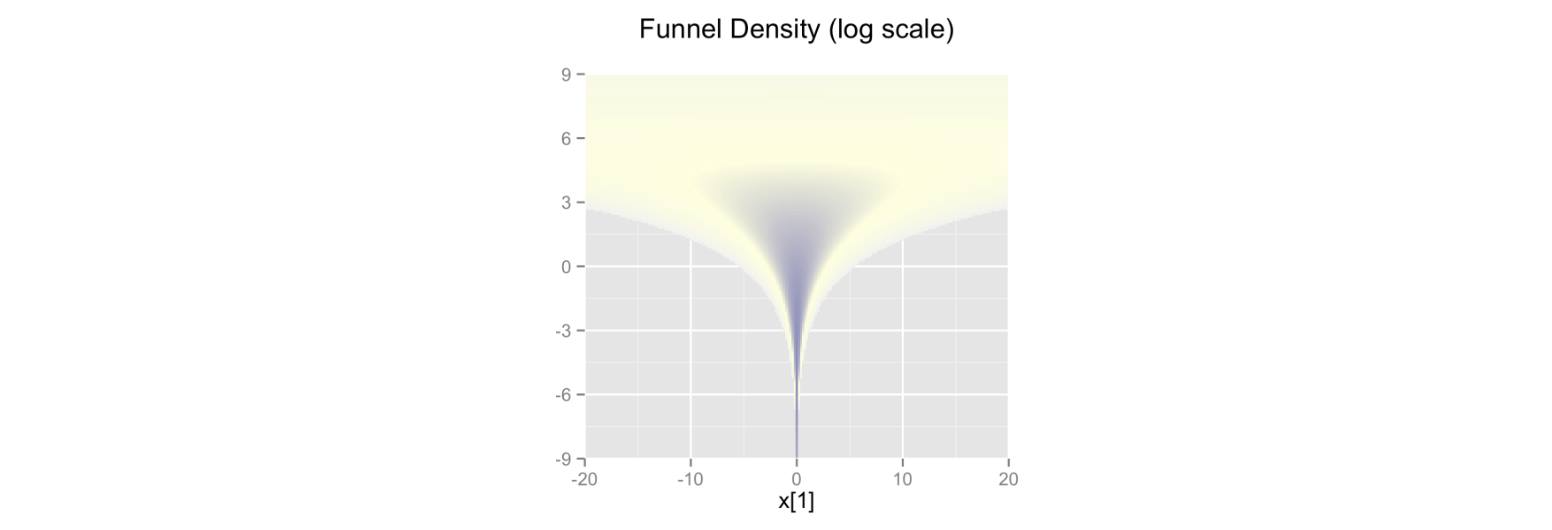

In [14]:
from IPython.display import Image

Image(filename='Neal_funnel_model_density.png') 

                                                 Figure 1

Figure1(url:https://mc-stan.org/docs/2_18/stan-users-guide/reparameterization-section.html)

## Model

In Bean Machine, we implement the model with factors. The factors are the things that add up to the target density, they can describe the distribution that you implement. For example, in the linear regression case, You can think about the factors as bias and weight for each random variable. Here, to implement Neal's funnel model in Bean Machine, we define the distribution by implementing its log prob. Bean Machine deals our implementation of log prob with factors. Then we can use that log prob to reach our target density. 

In [5]:
class Flat(dist.Distribution):
    has_enumerate_support = False
    support = dist.constraints.real
    has_rsample = True
    """
    :para infer_type :determine how you are sending the random variable to bean machine. 
    set infer_type == "Single-site", means you are sending the random variable one by one to Bean machine;
    set infer_type == "Global", you are going to send tensor random variable to Bean machine. 
    
    """
    
    def __init__(self, infer_type="Single-site"):
        self.infer_type = infer_type

    def rsample(self, sample_shape):
        return torch.zeros(sample_shape)
    
    def sample(self):
        if self.infer_type=="Single-site":
            return torch.tensor(0.0)
        else:
            return torch.tensor([0.0, 0.0])
    
    def log_prob(self, value):
        return torch.tensor(0.0)
    
    
class Target(dist.Distribution):
    has_enumerate_support = False
    support = dist.constraints.real
    has_rsample = True
    def __init__(self, x_foo, z_foo):
        super().__init__()
        self.x_foo = x_foo
        self.z_foo = z_foo
    
    def rsample(self, sample_shape):
        return torch.zeros(sample_shape)
    
    def sample(self):
        return torch.tensor(0.0)

    def log_prob(self, value):
        return dist.Normal(0.0, 3.0).log_prob(self.z_foo) + dist.Normal(0, (self.z_foo / 2).exp()).log_prob(self.x_foo)

  

## Inference

###  Single-site inference 

In single-site inference, we re-sample a single random variable and immediately accept or reject this sample. In the following examples, single-site inference would sample the random variables x() and z() as two nodes in a loop, and send them to decide to accept or reject individually. By doing these, single-site inference can control the variables to re-sample depending upon the random variable we wish to infer and its immediate neighborhood. 

In [6]:
class SingleSite(object):  
    
    @bm.random_variable
    def x(self):
        return Flat("Single-site")

    @bm.random_variable
    def z(self):
        return Flat("Single-site")

    @bm.random_variable
    def foo(self):
        return Target(self.x(), self.z())

### Global inference

In global inference, on the other hand, we re-sample all random variables and then decide to accept or reject them. In the following examples, global inference would sample the random variables (x(),z()) as one node. Once all random variable is re-sampled, we either accept or reject the new samples based on their probabilities.

In [7]:
class Global(object):
    
    @bm.random_variable
    def z(self):
        return Flat("Global")

    @bm.random_variable
    def foo(self):
        return Target(self.z()[0], self.z()[1])

So in the follwing part of the tutorial, we will cover: 
1. How to implement Neal's funnel in Bean Machine with two single-site inferences, Single-Site Newtonian Monte Carlo (Single-Site NMC), and Single-Site Hamiltonian Monte Carlo (Single-Site HMC).
2. How to implement Neal's funnel in Bean Machine with two global inferences, global NMC, and global HMC.

### Singele-site NMC

Single-Site Newtonian Monte Carlo [(Single-Site NMC)](https://arxiv.org/abs/2001.05567) is a second order method, which uses second order gradient to automatically scale the step size in each dimension. Thus, it can accurately recover the posterior marginal of the funnel (shown in its density plot in single-site NMC section).

In [33]:
num_sample = 10000
num_trial = 3

nw = bm.SingleSiteNewtonianMonteCarlo()  
model = SingleSite()
samples_nw = nw.infer([model.x(), model.z()], {model.foo(): tensor(0.0)}, num_sample, num_trial,verbose=VerboseLevel.OFF)

In [34]:
nw_x = [samples_nw.get_chain().get_variable(model.x())[i].item() for i in range(num_sample)]
nw_z = [samples_nw.get_chain().get_variable(model.z())[i].item() for i in range(num_sample)]
nw_x_ = samples_nw[model.x()].detach()
nw_z_ = samples_nw[model.z()].detach()

In [35]:
from beanmachine.ppl.diagnostics.common_statistics import effective_sample_size, split_r_hat,r_hat

print("x acceptance", len(torch.unique(nw_x_[0])) / len(nw_x_[0]),", effective sample size", effective_sample_size(nw_x_),", r hat", split_r_hat(nw_x_))
print("z acceptance", len(torch.unique(nw_z_[0])) / len(nw_z_[0]), ", effective sample size", effective_sample_size(nw_z_),", r hat", split_r_hat(nw_x_))

x acceptance 0.9954 , effective sample size tensor(25470.9551) , r hat tensor(0.9999)
z acceptance 0.6787 , effective sample size tensor(1155.2927) , r hat tensor(0.9999)


## Visualizations

Now we can make some plots to visualize our sampling results

In [23]:
from scipy.stats import norm
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib


def plot_samples(label, x_, z_,lim_x,lim_z, color):
    
    #scatter plots
    plt.scatter(lim_x,lim_z, s=2, color=color)
    plt.xlim(-150, 150)
    plt.ylim(-15, 15)
    plt.suptitle('Scatter plot_'+label, fontsize=16)
    plt.xlabel("z")
    plt.ylabel("x")

    
    #trace plot
    delta = 0.01
    x = np.arange(-5.0, 5.0, delta)
    z = np.arange(-15.0, 15.0, delta)
    X, Z = np.meshgrid(x, z)
    TARGET = dist.Normal(0.0, 3.0).log_prob(tensor(Z)) + dist.Normal(0, (tensor(Z) / 2).exp()).log_prob(tensor(X))

    fig, ax = plt.subplots()
    ax.contour(X, Z, TARGET, levels=range(-10, 0, 1))
    plt.plot(x_[0, :100], z_[0, :100], color=color)
    plt.xlabel("z")
    plt.ylabel("x")
    plt.suptitle('Trace plot_'+label, fontsize=16)
    plt.show()
    
    
    #parameterized density histograms
    plt.hist(lim_z, bins = np.linspace(-10, 10, 50), density = True, zorder=0, label=label, color=color)
    s = [0.001 * x for x in range(-10000, 10000)]
    y = [dist.Normal(0, 3).log_prob(x).exp() for x in s]
    plt.plot(s, y, linewidth=2, zorder=2, color="black", label="ground truth")
    plt.xlabel("z")
    plt.ylabel("density")
    plt.suptitle('Parameterized density histograms', fontsize=16)
    plt.legend()
    plt.show()
    
    #autocorrelation
    plt.subplot()
    plt.acorr(lim_x-np.mean(lim_x), maxlags=100,  normed=True, usevlines=False,label="x", color="red");
    plt.xlim( (0, 100))

    plt.acorr(lim_z-np.mean(lim_z), maxlags=100,  normed=True, usevlines=False,label="z", color="blue");
    plt.xlim( (0, 100))
    plt.ylabel(label+"_autocorrelation")
    plt.xlabel("lag")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

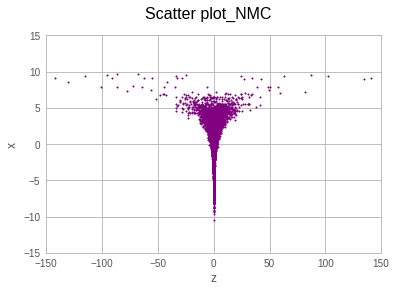

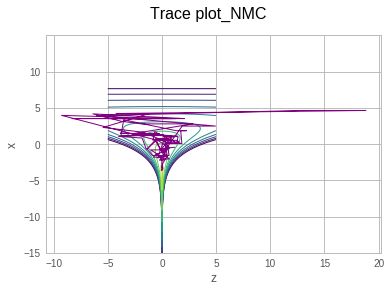

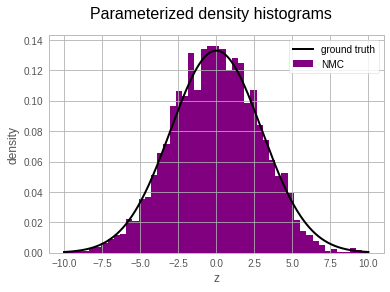

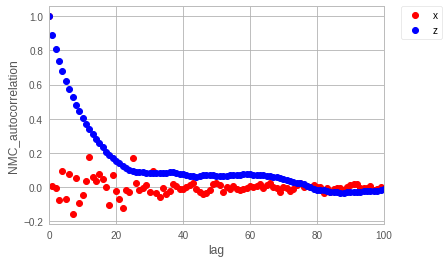

In [36]:
plot_samples("NMC", nw_x_, nw_z_,nw_x,nw_z,"purple")

From the scatter plot and trace plot, we can see, single-site NMC can explore the negative z region. In single-site NMC  parameterized density histogram, we can see posterior marginal of z in Neal’s funnel after 10,000 samples best match the curvature of the ground truth.

### Single-site HMC

Next we also sample with single-site HMC infernce, and compare the results with single-site NMC inference results.

In [511]:
num_sample = 10000
num_trial = 3

step_size = 0.5
num_steps = 1

hmc = SingleSiteHamiltonianMonteCarlo(step_size, num_steps)
model = SingleSite()
samples_hmc = hmc.infer([model.x(), model.z()], {model.foo(): tensor(0.0)}, num_sample, num_trial,verbose=VerboseLevel.OFF)

In [512]:
hmc_x = [samples_hmc.get_chain().get_variable(model.x())[i].item() for i in range(num_sample)]
hmc_z = [samples_hmc.get_chain().get_variable(model.z())[i].item() for i in range(num_sample)]
hmc_x_= samples_hmc[model.x()].detach()
hmc_z_= samples_hmc[model.z()].detach()

In [513]:
print("x acceptance", len(torch.unique(hmc_x_[0])) / len(hmc_x_[0]), ", effective sample size", effective_sample_size(hmc_x_),", r hat", split_r_hat(hmc_x_))
print("z acceptance", len(torch.unique(hmc_z_[0])) / len(hmc_z_[0]), ", effective sample size", effective_sample_size(hmc_z_),", r hat", split_r_hat(hmc_x_))

x acceptance 0.6462 , effective sample size tensor(175.6373) , r hat tensor(1.0176)
z acceptance 0.9508 , effective sample size tensor(399.9132) , r hat tensor(1.0176)


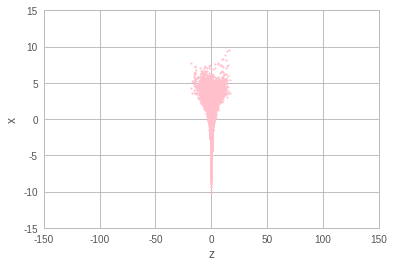

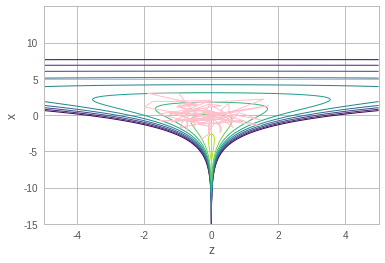

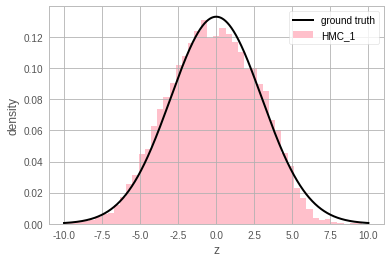

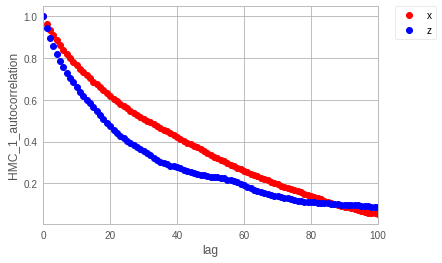

In [514]:
plot_samples("HMC_1",hmc_x_, hmc_z_,hmc_x,hmc_z,"pink")

### Single-site HMC (changing step size)

In [515]:
num_sample = 10000
num_trial = 3

step_size = 0.1
num_steps = 10

hmc = SingleSiteHamiltonianMonteCarlo(step_size, num_steps)
model = SingleSite()
samples_hmc = hmc.infer([model.x(), model.z()], {model.foo(): tensor(0.0)}, num_sample, num_trial,verbose=VerboseLevel.OFF)

In [516]:
hmc_10_x = [samples_hmc.get_chain().get_variable(model.x())[i].item() for i in range(num_sample)]
hmc_10_z = [samples_hmc.get_chain().get_variable(model.z())[i].item() for i in range(num_sample)]
hmc_10_x_= samples_hmc[model.x()].detach()
hmc_10_z_= samples_hmc[model.z()].detach()
print("x acceptance", len(torch.unique(hmc_10_x_[0])) / len(hmc_10_x_[0]), ", effective sample size", effective_sample_size(hmc_10_x_),", r hat", split_r_hat(hmc_10_x_))
print("z acceptance", len(torch.unique(hmc_10_z_[0])) / len(hmc_10_z_[0]), ", effective sample size", effective_sample_size(hmc_10_z_),", r hat", split_r_hat(hmc_10_x_))


x acceptance 0.0041 , effective sample size tensor(45.1330) , r hat tensor(1.0355)
z acceptance 0.0594 , effective sample size tensor(28.3629) , r hat tensor(1.0355)


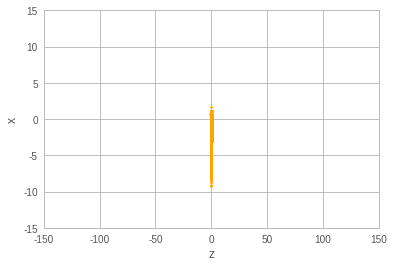

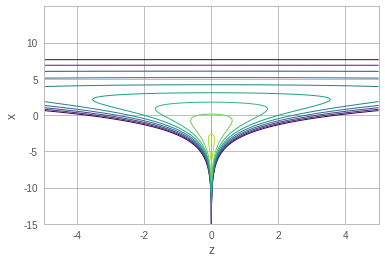

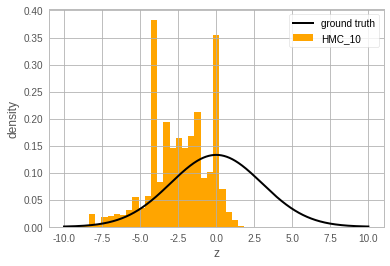

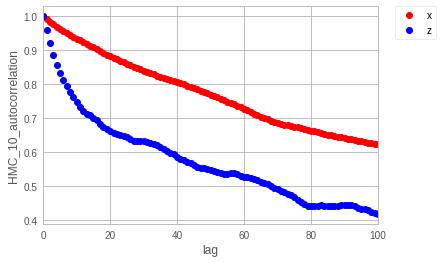

In [517]:
plot_samples("HMC_10",hmc_10_x_, hmc_10_z_,hmc_10_x,hmc_10_z,"orange")

### Global NMC

In [29]:
%silence 

num_sample = 10000
num_trial = 3

nw = bm.SingleSiteNewtonianMonteCarlo()
model = Global()
samples = nw.infer([model.z()], {model.foo(): tensor(0.0)}, num_sample, num_trial,verbose=VerboseLevel.OFF)

In [30]:
global_nw_x = [samples.get_chain().get_variable(model.z())[i,0].item() for i in range(num_sample)]
global_nw_z = [samples.get_chain().get_variable(model.z())[i,1].item() for i in range(num_sample)]
global_nw_x_ = samples[model.z()].detach()[:, :, 0]
global_nw_z_ = samples[model.z()].detach()[:, :, 1]

In [31]:
print("x acceptance", len(torch.unique(global_nw_x_[0])) / len(global_nw_x_[0]), ",effective sample size", effective_sample_size(global_nw_x_),", r hat", split_r_hat(global_nw_x_))
print("z acceptance", len(torch.unique(global_nw_z_[0])) / len(global_nw_z_[0]), ", effective sample size", effective_sample_size(global_nw_z_), ", r hat", split_r_hat(global_nw_z_))

x acceptance 0.0588 ,effective sample size tensor(41.2786) , r hat tensor(1.1277)
z acceptance 0.0588 , effective sample size tensor(4.4993) , r hat tensor(1.3352)


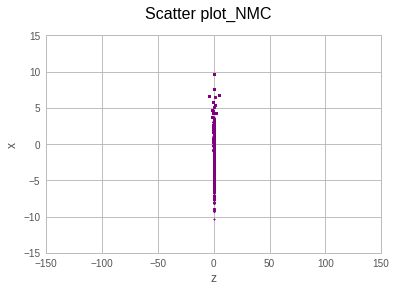

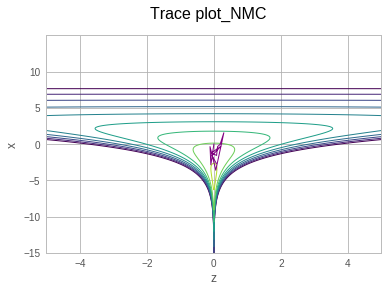

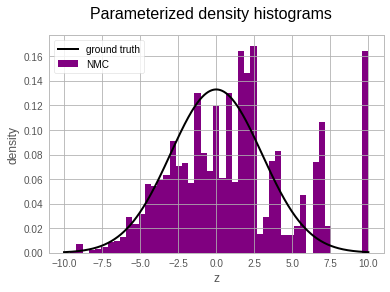

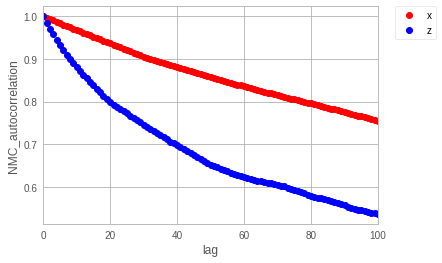

In [32]:
plot_samples("NMC", global_nw_x_,global_nw_z_,global_nw_x, global_nw_z, "purple")

In global inference, since we re-sample all the random variables, the second order methods have the problem to restrict x() and z(), so it causes problems for scaling the step size in each dimension, and current state can not make the reasonable probabilistic jump to next state. PPL team is currently continuing to develop the NMC inference algorithm to make it also work in global inference.

### Global HMC 

In [523]:
num_sample = 10000
num_trial = 3

step_size = 0.5
num_steps = 1

hmc = bm.SingleSiteHamiltonianMonteCarlo(step_size, num_steps)
model = Global()
samples_hmc = hmc.infer([model.z()], {model.foo(): tensor(0.0)}, num_sample, num_trial,verbose=VerboseLevel.OFF)

In [524]:
global_hmc_x = [samples_hmc.get_chain().get_variable(model.z())[i,0].item() for i in range(num_sample)]
global_hmc_z = [samples_hmc.get_chain().get_variable(model.z())[i,1].item() for i in range(num_sample)]
global_hmc_x_ = samples_hmc[model.z()].detach()[:, :, 0]
global_hmc_z_ = samples_hmc[model.z()].detach()[:, :, 1]

In [525]:
print("x acceptance", len(torch.unique(global_hmc_x_[0])) / len(global_hmc_x_[0]), ", effective sample size", effective_sample_size(global_hmc_x_),", r hat", split_r_hat(global_hmc_x_))
print("z acceptance", len(torch.unique(global_hmc_z_[0])) / len(global_hmc_z_[0]), ", effective sample size", effective_sample_size(global_hmc_z_),", r hat", split_r_hat(global_hmc_z_))

x acceptance 0.6495 , effective sample size tensor(214.0154) , r hat tensor(1.0064)
z acceptance 0.6494 , effective sample size tensor(248.0853) , r hat tensor(1.0083)


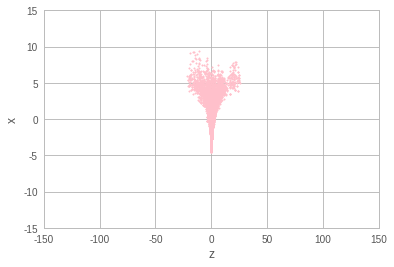

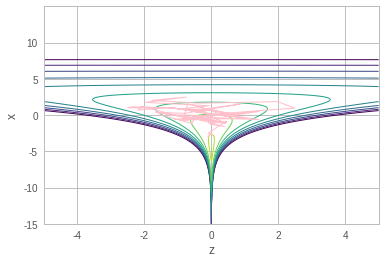

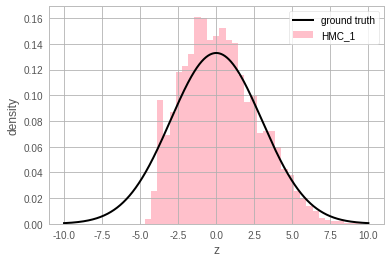

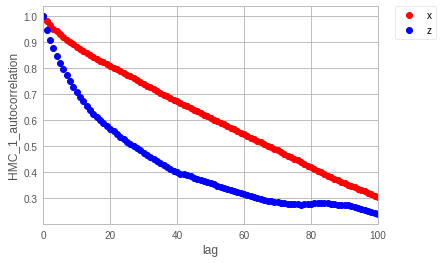

In [526]:
plot_samples("HMC_1",global_hmc_x_, global_hmc_z_,global_hmc_x,global_hmc_z,"pink")

### Global HMC (changing step size)

In [527]:
num_sample = 10000
num_trial = 3

step_size = 0.1
num_steps = 10

hmc = bm.SingleSiteHamiltonianMonteCarlo(step_size, num_steps)
model = Global()
samples_hmc = hmc.infer([model.z()], {model.foo(): tensor(0.0)}, num_sample, num_trial,verbose=VerboseLevel.OFF)

In [528]:
global_hmc_10_x = [samples_hmc.get_chain().get_variable(model.z())[i,0].item() for i in range(num_sample)]
global_hmc_10_z = [samples_hmc.get_chain().get_variable(model.z())[i,1].item() for i in range(num_sample)]
global_hmc_10_x_= samples_hmc[model.z()].detach()[:, :, 0]
global_hmc_10_z_= samples_hmc[model.z()].detach()[:, :, 1]

In [529]:
print("x acceptance", len(torch.unique(global_hmc_10_x_[0])) / len(global_hmc_10_x_[0]), ", effective sample size", effective_sample_size(global_hmc_10_x_),", r hat", split_r_hat(global_hmc_10_x_))
print("z acceptance", len(torch.unique(global_hmc_10_z_[0])) / len(global_hmc_10_z_[0]), ", effective sample size", effective_sample_size(global_hmc_10_z_),", r hat", split_r_hat(global_hmc_10_z_))

x acceptance 0.0016 , effective sample size tensor(270.3837) , r hat tensor(1.0235)
z acceptance 0.0016 , effective sample size tensor(16.3152) , r hat tensor(1.2041)


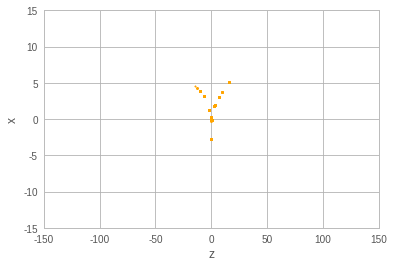

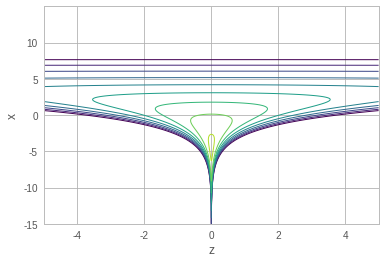

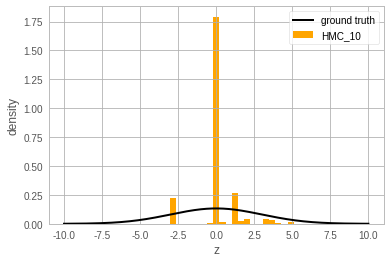

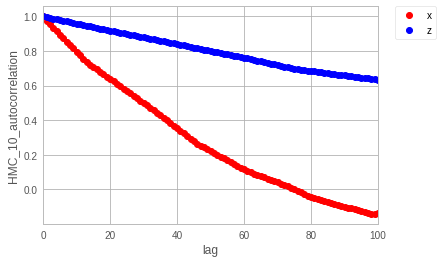

In [530]:
plot_samples("HMC_10",global_hmc_10_x_, global_hmc_10_z_,global_hmc_10_x,global_hmc_10_z,"orange")

## Reference

1. Neal, Radford M. 2003. “Slice Sampling.” Annals of Statistics 31 (3): 705–67.
2. Arora, N. S., Tehrani, N. K., Shah, K. D., Tingley, M., Li, Y. L., Torabi, N., ... & Meijer, E. (2020). Newtonian Monte Carlo: single-site MCMC meets second-order gradient methods. arXiv preprint arXiv:2001.05567.